In [22]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import sys

sys.path.append("../")
# add ../ to path


In [49]:
from helpers import load_csv_data
from feature_processing import (
    drop_columns,
    drop_correlated_columns,
    drop_single_value_columns,
    median_imputation,
    mean_imputation,
    standardize,
    build_poly,
    build_log,
    build_ratios,
    remove_outliers,
)
import matplotlib.pyplot as plt
from cross_validation import f1_score
from neural_network import (
    Fully_connected,
    ReLU,
    train,
    predict,
    iterate_minibatches,
)
import numpy as np

np.random.seed(0)


In [58]:
x_train, x_test, Y_train, train_ids, test_ids = load_csv_data("../../data")
# have 10% of the data as validation set
split_ratio = 0.9
split_index = int(len(x_train) * split_ratio)

In [59]:
X_train = x_train[:split_index]
y_train = Y_train[:split_index]

X_val = x_train[split_index:]
y_val = Y_train[split_index:]


In [60]:
y_train[np.where(y_train == -1)] = 0
y_val[np.where(y_val == -1)] = 0


In [65]:
### Column dropping and imputation ###
# threshold for drop_columns function
DROP_NAN_THRESHOLD = 1  # 1 = keep everything, 0 = drop everything that contains nan
# threshold for categorical/numerical (categorical are imputated with median, numerical with mean)
CAT_NUM_THRESHOLD = 200
# flag for drop_single_value_columns function
# Should always be True, otherwise it is messing up with the correlation coefficient.
DROP_SINGLE = True
# threshold for drop_correlated_columns function
DROP_CORR_THRESHOLD = 1
# remove outliers
REMOVE_OUTLIERS = False
### Feature processing ###
# flag for build_poly function
BUILD_POLY = False
# degree for build_poly function
DEGREE = 2
# flag for build_log function
BUILD_LOG = False
# flag for build_x
BUILD_RATIOS = False
# flag for standardize function
STANDARDIZE = True

In [66]:
x_train_temp = X_train.copy()
x_val_temp = X_val.copy()
x_test_temp = x_test.copy()


In [67]:
x_train_temp, cols_to_keep_1 = drop_columns(x_train_temp, DROP_NAN_THRESHOLD)
x_val_temp = x_val_temp[:, cols_to_keep_1]
x_test_temp = x_test_temp[:, cols_to_keep_1]
print(f"Dropping columns with DROP_NAN_THRESHOLD = {DROP_NAN_THRESHOLD}...")

# Identify categorical and numerical features
# categorical and numerical features
categorical_features = []
numerical_features = []
# find categorical and numerical features
for i, feature in enumerate(x_train_temp.T):
    if np.unique(feature).shape[0] < CAT_NUM_THRESHOLD:
        categorical_features.append(i)
    else:
        numerical_features.append(i)
# fill in missing values on the train and test
x_train_temp[:, categorical_features] = median_imputation(
    x_train_temp[:, categorical_features]
)
x_val_temp[:, categorical_features] = median_imputation(
    x_val_temp[:, categorical_features]
)
x_train_temp[:, numerical_features] = mean_imputation(
    x_train_temp[:, numerical_features]
)
x_val_temp[:, numerical_features] = mean_imputation(
    x_val_temp[:, numerical_features])
x_test_temp[:, categorical_features] = median_imputation(
    x_test_temp[:, categorical_features]
)
x_test_temp[:, numerical_features] = mean_imputation(
    x_test_temp[:, numerical_features])

if REMOVE_OUTLIERS:
    low_perc = np.percentile(x_train_temp, 2, axis=0)
    high_perc = np.percentile(x_train_temp, 100 - 2, axis=0)
    x_train_temp = remove_outliers(x_train_temp, low_perc, high_perc)
    x_val_temp = remove_outliers(x_val_temp, low_perc, high_perc)
    x_test_temp = remove_outliers(x_test_temp, low_perc, high_perc)

# Data engineering: ratios, log-transform, polynomial features
if BUILD_RATIOS:
    print("Building ratios...")
    ratio_features_train = build_ratios(x_train_temp[:, numerical_features])
    ratio_features_val = build_ratios(x_val_temp[:, numerical_features])
    ratio_features_test = build_ratios(x_test_temp[:, numerical_features])
    x_train_temp = np.hstack((x_train_temp, ratio_features_train))
    x_val_temp = np.hstack((x_val_temp, ratio_features_val))
    x_test_temp = np.hstack((x_test_temp, ratio_features_test))

if BUILD_LOG:
    print("Building log...")
    log_features_train = build_log(x_train_temp[:, numerical_features])
    log_features_val = build_log(x_val_temp[:, numerical_features])
    log_features_test = build_log(x_test_temp[:, numerical_features])
    x_train_temp = np.hstack((x_train_temp, log_features_train))
    x_val_temp = np.hstack((x_val_temp, log_features_val))
    x_test_temp = np.hstack((x_test_temp, log_features_test))

if BUILD_POLY:
    print("Building polynomial features...")
    x_train_temp = build_poly(x_train_temp, 2)
    x_val_temp = build_poly(x_val_temp, 2)
    x_test_temp = build_poly(x_test_temp, 2)
print(x_train_temp.shape)

# Drop columns with a single unique value or highly correlated columns
if DROP_SINGLE:
    x_train_temp, cols_to_keep_3 = drop_single_value_columns(x_train_temp)
    x_test_temp = x_test_temp[:, cols_to_keep_3]
    x_val_temp = x_val_temp[:, cols_to_keep_3]
    print("Dropping single valued columns...")

x_train_temp, cols_to_keep_2 = drop_correlated_columns(
    x_train_temp, DROP_CORR_THRESHOLD
)
x_val_temp = x_val_temp[:, cols_to_keep_2]
x_test_temp = x_test_temp[:, cols_to_keep_2]

# Standardize the datasets
if STANDARDIZE:
    print("Standardizing...")
    x_train_temp = standardize(x_train_temp)
    x_val_temp = standardize(x_val_temp)
    x_test_temp = standardize(x_test_temp)


Dropping columns with DROP_NAN_THRESHOLD = 1...
(295321, 321)
Dropping single valued columns...
Standardizing...


In [69]:
# NUM_FOLDS = 5
# # concatenatex x_train and x_val for cross validation
# # build k_indices for cross validation
# k_indices = build_k_indices(y_train, NUM_FOLDS, 42)
# cross_validation_nn(y_train, x_train_temp, k_indices)


In [57]:
# build neural network
network = []
network.append(Fully_connected(x_train_temp.shape[1], 128))
network.append(ReLU())
network.append(Fully_connected(128, 2))


Epoch 0
Train accuracy: 0.8549476671147667
F1 score train: 0.4127493316882583
Val accuracy: 0.8517096361309198
F1 score val: 0.40759678597516436
Epoch 1
Train accuracy: 0.8603384114235019
F1 score train: 0.4260447252334367
Val accuracy: 0.8563418053269946
F1 score val: 0.41571641051065944
Epoch 2
Train accuracy: 0.8626206737753157
F1 score train: 0.4326448419080116
Val accuracy: 0.8579874443834948
F1 score val: 0.42111801242236024
Epoch 3
Train accuracy: 0.8640191520413381
F1 score train: 0.4375
Val accuracy: 0.8585969403303468
F1 score val: 0.42245456808563603
Epoch 4
Train accuracy: 0.8653397489511413
F1 score train: 0.4411624181445154
Val accuracy: 0.8599378314134211
F1 score val: 0.42521260630315155


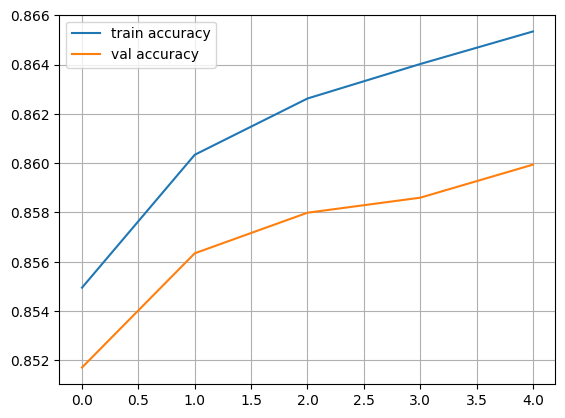

In [48]:
train_log = []
val_log = []

for epoch in range(5):
    for x_batch, y_batch in iterate_minibatches(
        x_train_temp, y_train, batchsize=1000, shuffle=True
    ):
        train(network, x_batch, y_batch)

    train_log.append(np.mean(predict(network, x_train_temp) == y_train))
    val_log.append(np.mean(predict(network, x_val_temp) == y_val))

    f1_val = f1_score(y_val, predict(network, x_val_temp))
    f1_train = f1_score(y_train, predict(network, x_train_temp))

    # return the best model from the cv according to the f1 score
    print("Epoch", epoch)
    print("Train accuracy:", train_log[-1])
    print("F1 score train:", f1_train)
    print("Val accuracy:", val_log[-1])
    print("F1 score val:", f1_val)

plt.plot(train_log, label="train accuracy")
plt.plot(val_log, label="val accuracy")
plt.legend(loc="best")
plt.grid()
plt.show()


In [35]:
y_predict = predict(network, x_test_temp)
y_predict[np.where(y_predict == 0)] = -1
np.unique(y_predict, return_counts=True)

(array([-1,  1]), array([92750, 16629]))